<a href="https://colab.research.google.com/github/Epilef86/Clusterizacao_Pratica/blob/main/E_Commerce_Kanggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

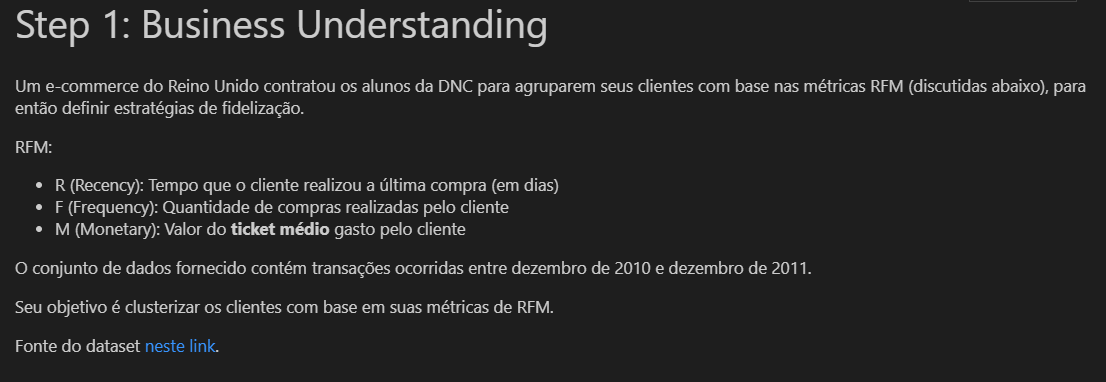

https://www.kaggle.com/datasets/carrie1/ecommerce-data

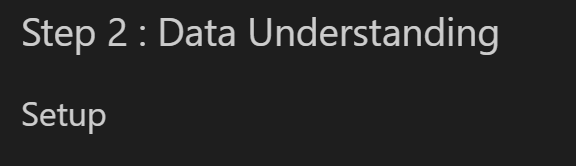

A biblioteca sidetable serve pra facilitar a contagem dos valores e mostrar os miss values

In [43]:
%%capture
%pip install sidetable

In [44]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

Função de customização dos gráficos

In [45]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

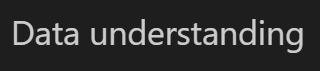

As colunas do dataset estão divididas em: 

número do pedido, código do estoque do produto, descrição, quantidade de produtos que foram comprados, data que foi feito o pedido, preço unitário, preço total pago nesse produto, ID do cliente e país de origem.

In [46]:
df = pd.read_csv('https://raw.githubusercontent.com/cmcouto-silva/datasets/main/datasets/e-commerce.csv', encoding='latin1')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


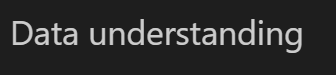

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Por que a coluna InvoiceNo está como object (string) ? Observe que tem string misturado com números...

In [48]:
df.InvoiceNo.sort_values()

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

Verificando quantos valores únicos cada país tem

In [49]:
df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

São 4.223 produtos únicos e 68 países únicos

In [50]:
df[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Vemos valores com quantidade abaixo de 0, unidades de preço abaixo de 0

<Axes: >

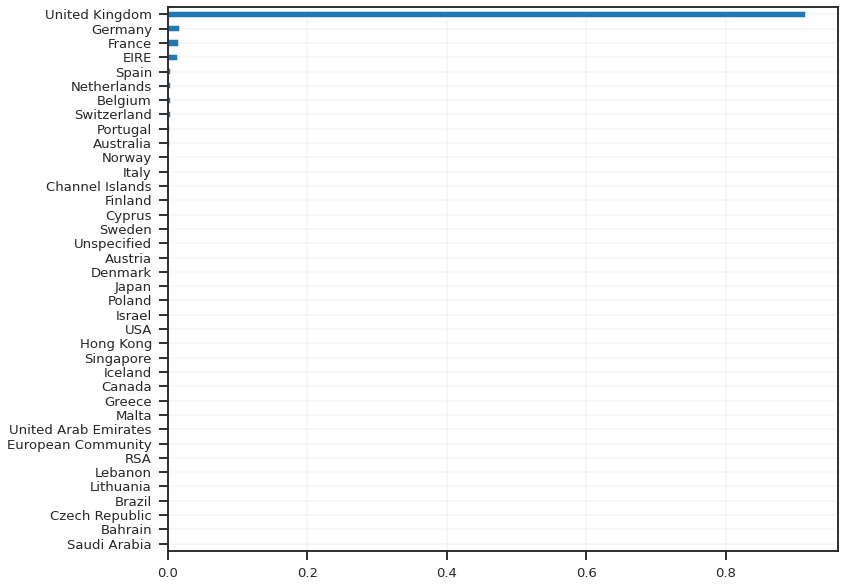

In [51]:
df['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10))

Temos vários países aonde a maioria é do reino unido, seguido pela alemanha, frança...ect

Se usar a biblioteca stb, ela retorna uma lista com o país, a contagem...se considerar os 10 primeiros paises, eles representam 98.64 % dos dados

In [52]:
df.stb.freq(['Country'])  

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [53]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Verificando se tem valores duplicados

In [54]:
df.isna().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

Existem bastante valores duplicados pro ID do cliente e pra descrição do produto.

Verificando se têm linhas duplicadas no dataset

In [55]:
df.duplicated().sum()

5268

Têm 5.268 linhas duplicadas

In [56]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


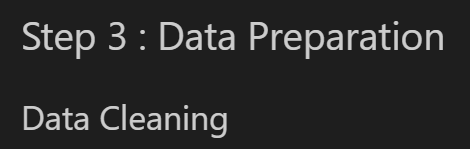

Temos 135.080 valores nulos, que representa 24.92 % dos dados.

E 1.454 itens da descrição faltando também

In [57]:
df.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
InvoiceNo,0,541909,0.000000
StockCode,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


Posso clusterizar sem o CustomerID ? Não porque iremos precisar calcular o ticket médio dos clientes. Nesse caso não tem o que fazer, precisamos excluir esses clientes.

In [58]:
df = df.dropna(subset=['CustomerID'])

Mostrando novamente os valores faltantes

In [59]:
df.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


Observe que não têm mais nenhum valor faltante, inclusive na Description

Precisamos converter a coluna InvoiceDate pra tipo DateTime

%%timeit serve pra mostra o tempo gasto pra fazer a conversão pra DateTime

In [60]:
%%timeit
pd.to_datetime(df.InvoiceDate)

3.22 s ± 1.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Demorou 1.98 s, rodou 7 vezes pra converter 

Usando outra forma de conversão...

In [61]:
%%timeit
pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

119 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Demorou 125 ms, rodou 7 vezes pra converter, ou seja, bem mais rápido..

Utilizando o código acima pra atualizar a coluna

In [62]:
df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')

<ipython-input-62-0a4a47e6cb3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['InvoiceDate'] = pd.to_datetime(df.InvoiceDate, format='%m/%d/%Y %H:%M')


Convertendo CustomerID pra inteiro e convertendo a coluna Country pro tipo categoria do Pandas

In [63]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['Country'] = df['Country'].astype('category')

<ipython-input-63-8861d7906295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)
<ipython-input-63-8861d7906295>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country'] = df['Country'].astype('category')


Vou fazer uma cópia pra não ficar enviando mensagens de aviso toda hora

In [64]:
df = df.copy()

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


Pra descobrir qual foi a primeira e última data

In [66]:
df.InvoiceDate.agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

Descobrindo quais colunas não estão iguais ou abaixo de 0

In [67]:
below0 = df[['Quantity','UnitPrice']].le(0).any(axis=1)
df = df[~below0].copy()

In [68]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


Já que vamos trabalhar apenas com duas colunas, vou fazer um gráfico

<Axes: >

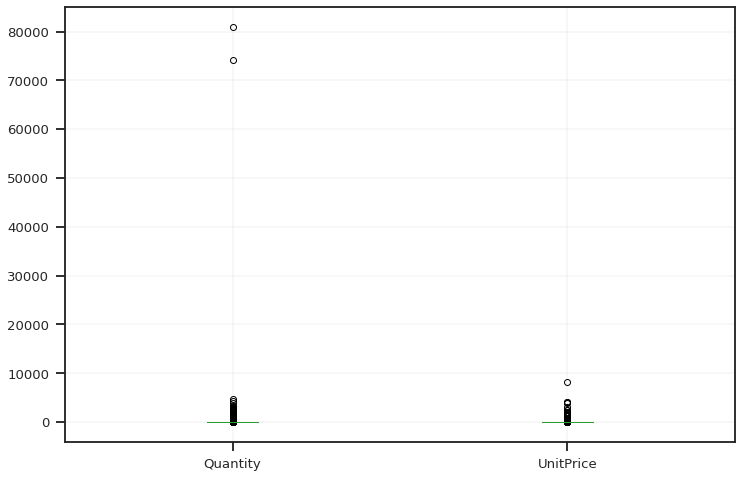

In [69]:
df[['Quantity','UnitPrice']].plot.box()

Têm valores extremamente altos. Vou explorar eles pra ver ..

In [70]:
df.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


Vpu ignorá-los e plotar box plot

<Axes: >

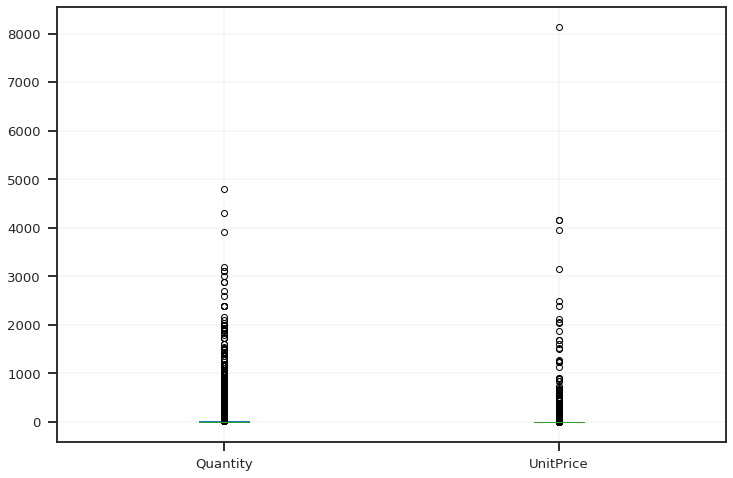

In [71]:
df.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box()

Ainda tem bastante outliers. O que pode ser feito é uma transformação pra reduzir outliers ou considerar como uma verdade

Vou verificar esse outlier

In [72]:
df.query('UnitPrice>8_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


Vou remover esse outlier

In [73]:
df = df.query('Quantity<10_000 & UnitPrice<8_000').copy()

Criando uma coluna pra pegar o preço total

In [74]:
df['price_total'] = df.Quantity * df.UnitPrice
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


Calculando o RFM

In [75]:
pd.Timestamp.today()

Timestamp('2023-03-27 21:38:22.122303')

Colocando uma data qualquer...

In [76]:
pd.Timestamp('2012-01-01')

Timestamp('2012-01-01 00:00:00')

Vou agrupar pelo ID cliente. 

Dentro do agg vou passar os parâmetros de uma tupla: o nome da coluna que existe no dataset, e o segundo valor é a função aplicada a cada cliente; quero pegar a data de hoje menos a data da última conta para cada cliente em dias;

Calculando a frequência fazendo verificando quantos itens comprou no total ou quantos pedidos ele comprou no total. Depende da estratégia que se queira usar. Vou verificar quantos pedidos únicos foram feitos. Lembrando que pedido para cada produto pode ter múltiplos produtos com múltiplas quantidades;

Ticket Médio preço total e a média



In [77]:
df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('2012-01-01') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('price_total', 'mean')
  )
)

df_rfm

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


Temos a tabela de R F M

Como estão em escalas diferentes ficam com valores diferentes vou escalonar usando scale

<Axes: >

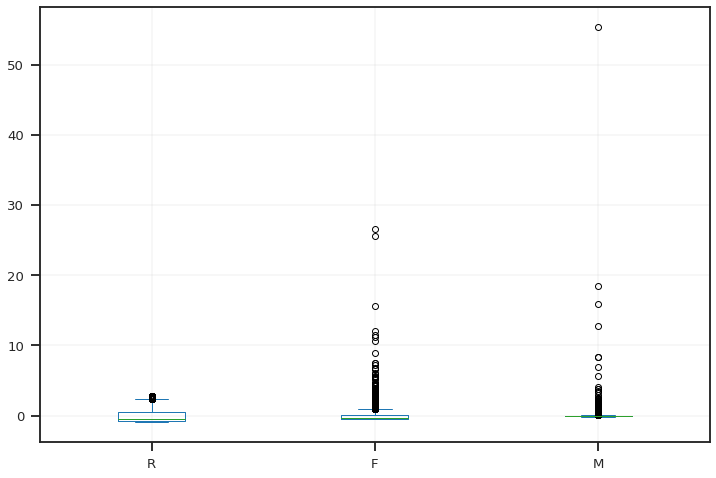

In [78]:
df_rfm.apply(scale).plot.box()

Vemos que a rescencia tem outlier mas não tanto quando comparado com as demais. O eixo y é o desvio padrão

Verificando o outlier > 50

In [79]:
df_rfm.apply(scale).query('M>50')

,R,F,M
CustomerID,,,
15098,0.899878,-0.165317,55.434876


Verificando quem é esse cliente

In [80]:
df.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


Vou excluir esse cliente

In [81]:
df_rfm = df_rfm.drop(15098)

<Axes: >

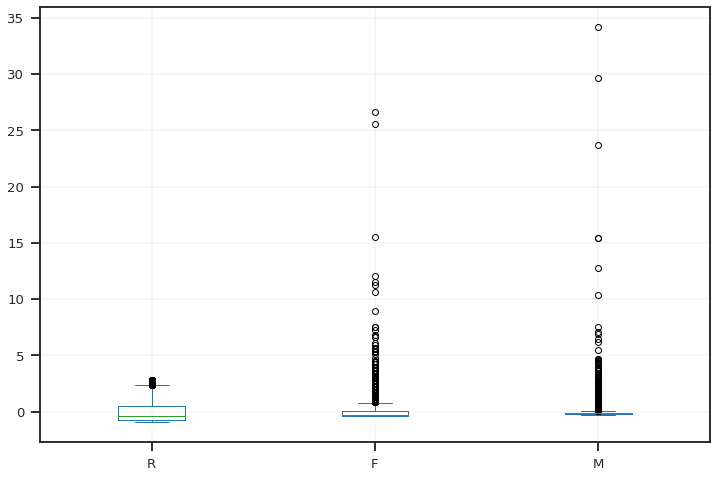

In [82]:
df_rfm.apply(scale).plot.box()

Fazendo uma normalização do sklearn

In [83]:
from sklearn.preprocessing import PowerTransformer

In [84]:
scaler = PowerTransformer()

Passando pra um formato de DataFrame pq por padrão é retornado um array

In [85]:
df_rfm_scaled = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm_scaled

,R,F,M
CustomerID,,,
12347,-1.563219,1.201866,0.407836
12348,0.323470,0.660670,1.329304
12349,-0.809134,-1.158070,0.426829
12350,1.568467,-1.158070,0.189376
12352,-0.307718,1.309671,0.653411
...,...,...,...
18280,1.475652,-1.158070,0.085562
18281,1.107356,-1.158070,-0.491003
18282,-1.275046,-0.195707,-0.161007


<Axes: >

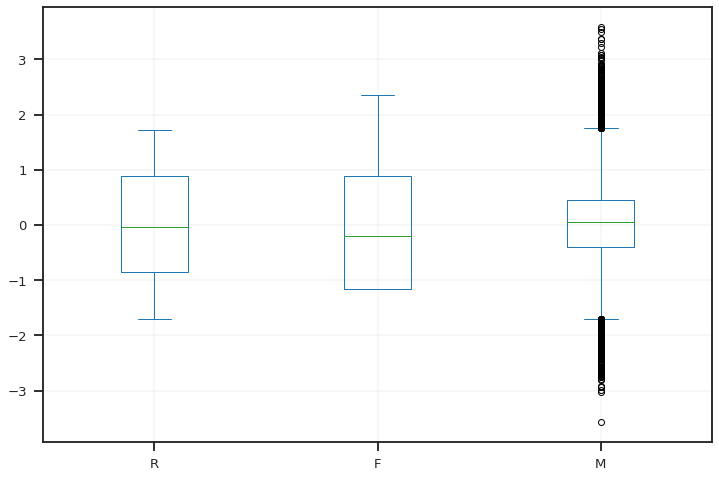

In [86]:
df_rfm_scaled.plot.box()

Reforçando, não foi excluido nenhum valor de R, F ou M

Caso eu queira trazer de volta o dataset, ou seja, o valor que foi normalizado voltou pra os valores originais.

In [87]:
scaler.inverse_transform(df_rfm_scaled)

array([[24.        ,  7.        , 23.68131868],
       [97.        ,  4.        , 57.97548387],
       [40.        ,  1.        , 24.0760274 ],
       ...,
       [29.        ,  2.        , 14.8375    ],
       [25.        , 16.        ,  2.77100529],
       [64.        ,  3.        , 26.24685714]])

Dando um describe pra os valores originais

In [88]:
df_rfm.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.272601,34.554185
std,99.968352,7.697927,129.202663
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,395.000000,209.000000,4453.430000


Vemos que de Ressencia a mediana é 72 e o valor máximo é de 333. A frequencia tem um outlier muito grande pq a mediana tem valor 2, 75 % dos dados tem valor de 5 ou menos, e o valor máximo tá 209.

Vou baixa todos os valores que são acima de um valor de ressencia vou atribuido um valor máximo

Vou pegar a coluna, dar um clip. Vou reduzir para que o valor superior no máximo possa ser o quantil de 95 % 

In [89]:
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.634656
std,95.504576,3.358999,20.993635
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,333.000000,13.000000,91.768421


Vou padronizar usando a função scale

In [90]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)

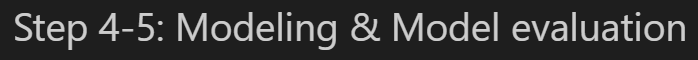

Existem três modelos que vão ser testado: KMeans, hierarchical clustering e gaussian mixture

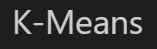

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

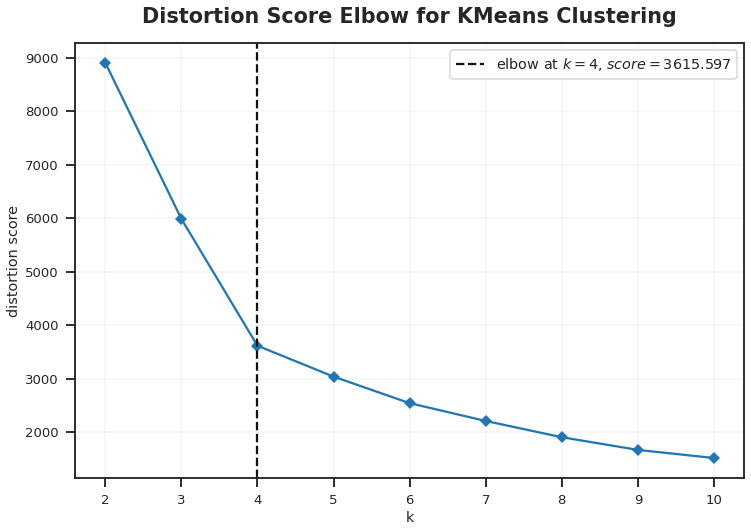

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [91]:
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

Retorna 4 grupos pra fazer. 

Vendo pelo silhouette também pra comparar...

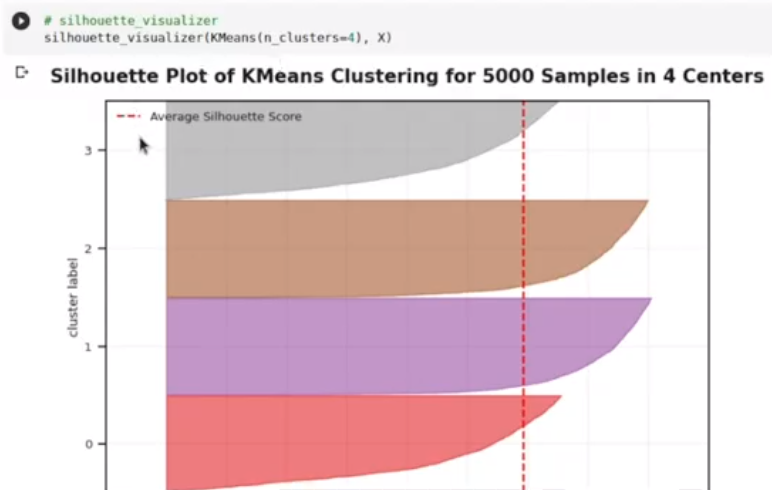

In [93]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8906.589803,0.382311,1.065369,1995.770793
3,5987.858046,0.434196,0.858749,2539.996344
4,3615.604890,0.479553,0.704462,3751.144746
5,3038.351886,0.484991,0.737341,3552.793389
6,2542.498169,0.398087,0.851009,3564.654984
7,2209.186985,0.376864,0.870175,3526.795460
8,1907.066277,0.383598,0.862066,3599.016667
9,1668.785587,0.394119,0.800873,3675.190014
10,1516.641890,0.351595,0.887744,3641.963320


In [94]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [95]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

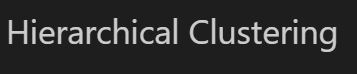

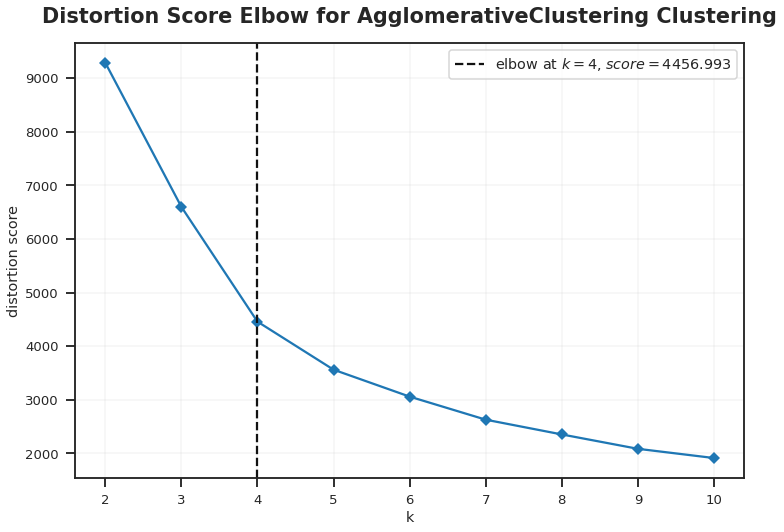

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [96]:
kelbow_visualizer(AgglomerativeClustering(), df_rfm_clip_scaled, k=10, timings=False)

In [97]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  # cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.361292,1.331666,1737.623791
3,0.398928,0.869855,2104.783905
4,0.431886,0.761966,2770.399918
5,0.342136,0.897329,2872.239315
6,0.348298,0.791909,2816.854970
7,0.322680,0.844326,2848.491623
8,0.287643,0.967432,2799.001327
9,0.286883,0.976982,2832.797336
10,0.298923,0.953087,2786.657350


In [98]:
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(df_rfm_clip_scaled)

In [99]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=hclust_labels.astype(str), template='plotly_dark')

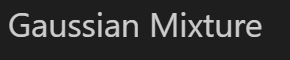

In [100]:
# Select best model by covariance type and K (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = df_rfm_clip_scaled.copy()

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
30,-8.477864,8,diag
28,-7.568421,8,full
24,205.096757,7,full
26,216.348730,7,diag
22,9501.926696,6,diag


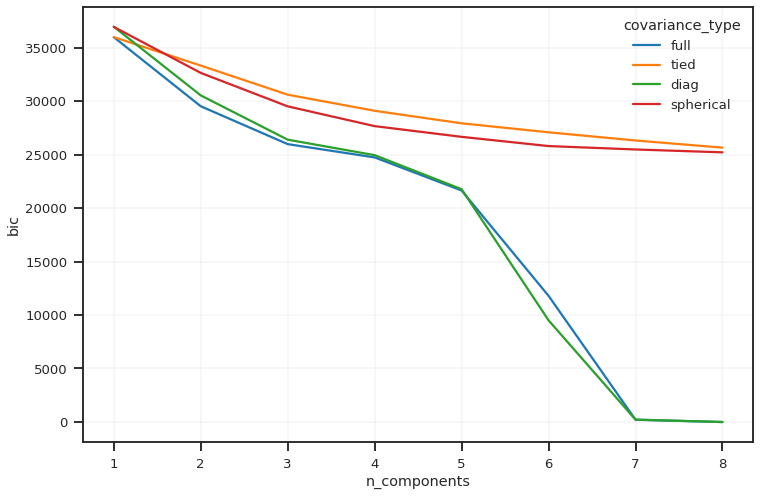

In [101]:
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

In [102]:
mclust = GaussianMixture(n_components=5, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(df_rfm_clip_scaled)

In [103]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=mclust_labels.astype(str), template='plotly_dark')

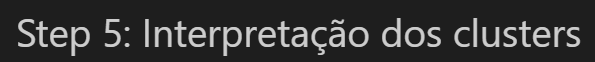

NameError: ignored

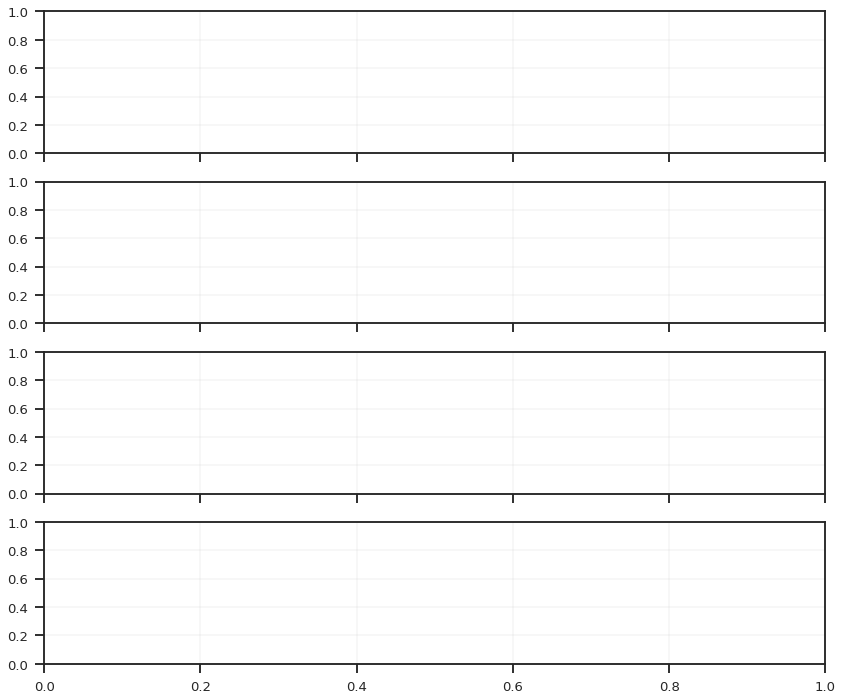

In [106]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none') 

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [105]:
(
  df_rfm_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1)
)

cluster,0,1,2,3
R,67.523221,261.082051,121.057935,41.517018
F,2.703877,1.509744,3.876574,10.191248
M,17.120301,18.104189,80.714098,20.426973
